### Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import nltk
import tensorflow as tf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    pipeline,
    BertTokenizer,
    BertForSequenceClassification,
    BertModel,
    Trainer,
    TrainingArguments,
    TrainerCallback,
    EarlyStoppingCallback,
)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    accuracy_score,
    mean_squared_error,
    r2_score,
    f1_score,
)

import seaborn as sns
from scipy import stats

from datasets import Dataset
from collections import defaultdict

c:\Users\drebi\miniconda3\envs\FinBERT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Transforming the data

In [2]:

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-merged dataset of news and price data
price_df = pd.read_csv('data/price.csv')
news_df = pd.read_csv('data/news.csv')

price_df['daily_return'] = price_df.groupby('ticker')['close'].transform(lambda x: x.pct_change())
price_df = price_df.dropna()

# Convert dates to datetime
news_df['publication_datetime'] = pd.to_datetime(news_df['publication_datetime'])
price_df['Date'] = pd.to_datetime(price_df['Date'])

price_df = price_df.sort_values(['ticker', "Date"])
price_df['daily_return'] = price_df.groupby('ticker')['close'].pct_change()

news_df = news_df.rename(columns={'tickers': 'ticker'})

merged_df = pd.merge_asof(
    news_df.sort_values('publication_datetime'),
    price_df.sort_values('Date'),
    by='ticker',
    left_on='publication_datetime',
    right_on='Date',
    direction='backward'
)
merged_df = merged_df.dropna(subset=['daily_return'])

# Keep the date column for splitting
merged_df = merged_df[["title", "body", "daily_return", "Date"]].dropna()
merged_df["text"] = merged_df["title"] + " " + merged_df["body"]
merged_df["label"] = (merged_df["daily_return"] > 0).astype(int)
merged_df["label"] = merged_df["label"].astype(float)


Using device: cuda


# Time Series Split

We use a time series split for the training, validation and testing method. We use months prior to 2019 for training, the year 2019 for validation and the year 2020 for testing

In [3]:

# Split data based on dates
train_mask = merged_df['Date'] < '2019-01-01'
val_mask = (merged_df['Date'] >= '2019-01-01') & (merged_df['Date'] < '2020-01-01')
test_mask = merged_df['Date'] >= '2020-01-01'


## Data Cleaning

In [4]:

# Create clean dataframes with only the columns we need
train_df = pd.DataFrame({
    'text': merged_df.loc[train_mask, 'text'].values,
    'label': merged_df.loc[train_mask, 'label'].values
})
val_df = pd.DataFrame({
    'text': merged_df.loc[val_mask, 'text'].values,
    'label': merged_df.loc[val_mask, 'label'].values
})
test_df = pd.DataFrame({
    'text': merged_df.loc[test_mask, 'text'].values,
    'label': merged_df.loc[test_mask, 'label'].values
})

# Ensure all values are numeric
train_df['label'] = train_df['label'].astype(float)
val_df['label'] = val_df['label'].astype(float)
test_df['label'] = test_df['label'].astype(float)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Create datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)


Training set size: 10292
Validation set size: 5338
Test set size: 4892


In [5]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 4892/4892 [00:41<00:00, 116.53 examples/s]


## Performance Parameters


This code implements a metrics tracking system for a machine learning model, specifically for binary classification. The `compute_metrics` function processes model predictions by handling various input formats (tuples or prediction objects), converting PyTorch tensors to NumPy arrays when needed, and calculating classification metrics including accuracy and mean squared error. It transforms logits into probabilities using the sigmoid function and converts them to binary predictions using a 0.5 threshold. 

The code also defines a custom `MetricsCallback` class that inherits from `TrainerCallback` (likely from the Hugging Face Transformers library) to track training and validation metrics throughout the training process. This callback stores loss values in dedicated dictionaries and prints progress updates at each step, providing real-time monitoring of model performance during training.

In [6]:

def compute_metrics(pred):
    # Handle the prediction format correctly
    if isinstance(pred, tuple):
        if len(pred) == 2:
            logits, labels = pred
        else:
            logits = pred[0]
            labels = pred[1]
    else:
        logits = pred.predictions
        labels = pred.label_ids
    
    # Ensure we have the right shape
    if len(logits.shape) > 1:
        logits = logits.squeeze()
    
    if isinstance(logits, torch.Tensor):
        logits = logits.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    
    # Ensure we're working with float arrays
    logits = logits.astype(np.float32)
    labels = labels.astype(np.float32)
    
    probs = 1 / (1 + np.exp(-logits))
    preds = (probs > 0.5).astype(int)
    
    # Calculate additional metrics
    mse = mean_squared_error(labels, probs)
    
    metrics = {
        "accuracy": accuracy_score(labels, preds),
        "mse": mse
    }
    return metrics

# Initialize dictionaries to store metrics
train_metrics = defaultdict(list)
val_metrics = defaultdict(list)

# Enhanced metrics callback
class MetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            # Check for training loss
            if "loss" in logs:
                train_metrics["loss"].append(logs["loss"])
            # Check for eval loss
            if "eval_loss" in logs:
                val_metrics["loss"].append(logs["eval_loss"])
            # Print current metrics
            print(f"Step {state.global_step}: ", end="")
            if "loss" in logs:
                print(f"Training Loss: {logs['loss']:.4f}", end=" ")
            if "eval_loss" in logs:
                print(f"Eval Loss: {logs['eval_loss']:.4f}", end=" ")
            print()

## Fine-Tuned BERT Model

The following is a BERT-based model with a custom fully connected classifier head. Here's the architecture outline:

1. Base Model: 
* Uses "yiyanghkust/finbert-tone" pre-trained BERT model
* Specialized for financial text processing and sentiment analysis
* The BERT parameters are initially frozen to leverage pre-trained knowledge
2. Classifier Head (Fully Connected Network):
* Progressive dimension reduction across three layers:
* First layer: 768 → 384 neurons with LayerNorm, ReLU activation, and 50% dropout
* Second layer: 384 → 192 neurons with LayerNorm, ReLU activation, and 40% dropout
* Output layer: 192 → 1 neuron with 30% dropout for final prediction
3. Training Approach
* Uses Binary Cross-Entropy with Logits Loss for binary classification
* Input text is tokenized with attention masking
* The model outputs a single logit representing sentiment prediction

This architecture employs LayerNorm instead of BatchNorm for normalization and uses relatively high dropout rates (decreasing from 50% to 30%) to prevent overfitting. The network processes financial text to predict sentiment (likely positive/negative) with just three layers, maintaining efficiency while still allowing for deep feature extraction.

In [7]:

class FinBERTWithClassifier(nn.Module):
    def __init__(self):
        super(FinBERTWithClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("yiyanghkust/finbert-tone")
        
        # Freeze BERT layers initially
        for param in self.bert.parameters():
            param.requires_grad = False
            
        # Modified classifier network with new dimensions and dropout rates
        self.classifier = nn.Sequential(
            nn.Linear(768, 384),
            nn.LayerNorm(384),  # Changed from BatchNorm to LayerNorm
            nn.ReLU(),
            nn.Dropout(0.5),    # Changed dropout rate
            
            nn.Linear(384, 192),
            nn.LayerNorm(192),  # Changed from BatchNorm to LayerNorm
            nn.ReLU(),
            nn.Dropout(0.4),    # Changed dropout rate
            
            nn.Linear(192, 1),
            nn.Dropout(0.3)     # Final dropout rate
        )
        self.to(device)

    def forward(self, input_ids, attention_mask, labels=None):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        if labels is not None:
            labels = labels.to(device)
            
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        
        logits = self.classifier(pooled_output).squeeze(-1)

        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels.float())
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

## Training

This code is configuring training parameters for a machine learning model using the Hugging Face Transformers library. It creates a TrainingArguments object that defines key training settings including: 
* training for 15 epochs
* using a learning rate of 2e-5 with cosine scheduling and 10% warmup
* batch sizes of 16 samples per device
* weight decay of 0.01 for regularization
* gradient accumulation over 4 steps to handle larger effective batch sizes,
* mixed precision training with fp16
* and evaluation/saving at each epoch.

In [8]:

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=15,  # This will run for all 15 epochs
    weight_decay=0.01,
    warmup_ratio=0.1,
    gradient_accumulation_steps=4,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    lr_scheduler_type="cosine",
    logging_strategy="epoch",
    logging_dir="./logs",
    report_to=["tensorboard"]
)

c:\Users\drebi\miniconda3\envs\FinBERT\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Training and Validation Loss

Epoch,Training Loss,Validation Loss,Accuracy,Mse
1,0.742900,0.713066,0.463657,0.259871
2,0.716200,0.693655,0.491383,0.250254
3,0.709000,0.700787,0.463844,0.253811
4,0.703900,0.693777,0.483327,0.250315
5,0.701900,0.697171,0.463844,0.252010
6,0.699400,0.694356,0.466654,0.250604
7,0.698400,0.692631,0.523417,0.249742
8,0.698500,0.693348,0.499251,0.250100
9,0.698000,0.692511,0.531660,0.249682
10,0.698700,0.692806,0.518921,0.249829


Step 161: Training Loss: 0.7429 
Step 161: Eval Loss: 0.7131 
Step 322: Training Loss: 0.7162 
Step 322: Eval Loss: 0.6937 
Step 483: Training Loss: 0.7090 
Step 483: Eval Loss: 0.7008 
Step 644: Training Loss: 0.7039 
Step 644: Eval Loss: 0.6938 
Step 805: Training Loss: 0.7019 
Step 805: Eval Loss: 0.6972 
Step 966: Training Loss: 0.6994 
Step 966: Eval Loss: 0.6944 
Step 1127: Training Loss: 0.6984 
Step 1127: Eval Loss: 0.6926 
Step 1288: Training Loss: 0.6985 
Step 1288: Eval Loss: 0.6933 
Step 1449: Training Loss: 0.6980 
Step 1449: Eval Loss: 0.6925 
Step 1610: Training Loss: 0.6987 
Step 1610: Eval Loss: 0.6928 
Step 1771: Training Loss: 0.6974 
Step 1771: Eval Loss: 0.6924 
Step 1932: Training Loss: 0.6987 
Step 1932: Eval Loss: 0.6921 
Step 2093: Training Loss: 0.6973 
Step 2093: Eval Loss: 0.6924 
Step 2254: Training Loss: 0.6974 
Step 2254: Eval Loss: 0.6924 
Step 2415: Training Loss: 0.6977 
Step 2415: Eval Loss: 0.6923 
Step 2415: 


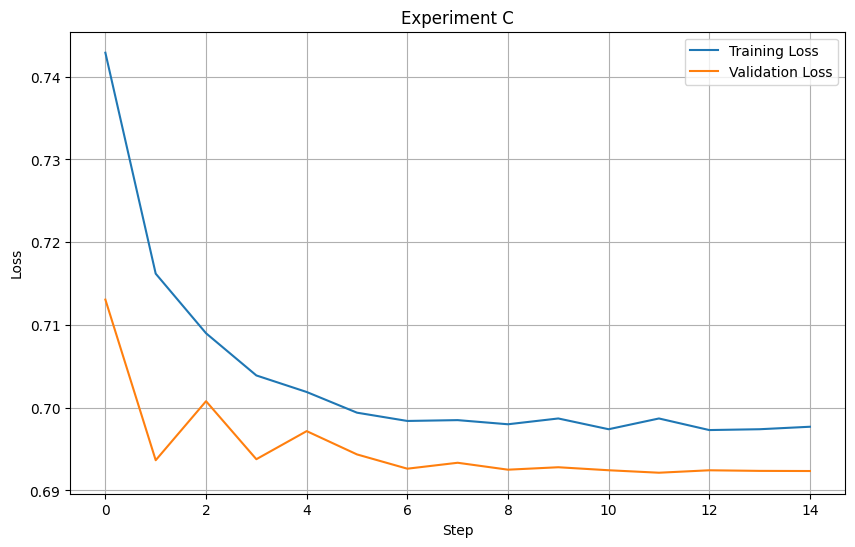

In [9]:

model = FinBERTWithClassifier()
# Initialize the trainer with callbacks
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[MetricsCallback()]  # Only include the metrics callback
)
trainer.train()

# Plot training and validation loss curves

plt.figure(figsize=(10, 6))
if train_metrics["loss"]:  # Check if we have training loss data
    plt.plot(train_metrics["loss"], label="Training Loss")
if val_metrics["loss"]:  # Check if we have validation loss data
    plt.plot(val_metrics["loss"], label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Experiment C")
plt.legend()
plt.grid(True)
plt.savefig("loss_curves.png")
plt.show()


## Testing

Finally, the model evaluates a trained sentiment analysis model on a test dataset and generates predictions. First, it runs the model on the test set and prints evaluation metrics. Then it gets raw prediction logits, converts them to probabilities using the sigmoid function, and thresholds them at 0.5 to classify text as either "Positive" or "Negative". 

It also calculates confidence scores for each prediction. The code then creates a comprehensive DataFrame containing the original text, true labels (both numeric and text format), predicted sentiment labels, and confidence scores. 

Finally, it exports all these predictions to a CSV file named 'test_predictions.csv' for further analysis or reporting.

In [10]:
# After training, evaluate on test set
test_results = trainer.evaluate(test_dataset)
print("\nTest Set Results:")
print(test_results)

# Get predictions for the test set
test_preds = trainer.predict(test_dataset)
test_probs = 1 / (1 + np.exp(-test_preds.predictions))
test_labels = test_preds.label_ids

# Create sentiment predictions and scores
test_predictions = np.where(test_probs > 0.5, 'Positive', 'Negative')
sentiment_scores = np.where(test_probs > 0.5, test_probs, 1 - test_probs)

# Create output dataframe
predictions_df = pd.DataFrame({
    'text': test_df['text'].values,
    'true_label': test_labels,
    'true_sentiment': np.where(test_labels > 0.5, 'Positive', 'Negative'),
    'predicted_sentiment': test_predictions,
    'sentiment_score': sentiment_scores
})

# Save predictions to CSV
predictions_df.to_csv('predictions/test_predictions_C.csv', index=False)

Step 2415: Eval Loss: 0.6932 

Test Set Results:
{'eval_loss': 0.6932070851325989, 'eval_accuracy': 0.49550286181520853, 'eval_mse': 0.250029981136322, 'eval_runtime': 11.8848, 'eval_samples_per_second': 411.619, 'eval_steps_per_second': 25.747, 'epoch': 15.0}


In [11]:

# Print sample predictions
print("\nSample Sentiment Predictions:")
for i in range(min(5, len(predictions_df))):
    print(f"\nText: {predictions_df['text'].iloc[i][:200]}...")
    print(f"True Sentiment: {predictions_df['true_sentiment'].iloc[i]}")
    print(f"Predicted Sentiment: {predictions_df['predicted_sentiment'].iloc[i]}")
    print(f"Sentiment Score: {predictions_df['sentiment_score'].iloc[i]:.2f}")
    print("---")

test_metrics = {
    "accuracy": accuracy_score(test_labels, (test_probs > 0.5).astype(int)),
    "mse": mean_squared_error(test_labels, test_probs),
    "r2": r2_score(test_labels, test_probs),
    "f1": f1_score(test_labels, (test_probs > 0.5).astype(int))
}
print("\nTest Set Metrics:")
print(test_metrics)



Sample Sentiment Predictions:

Text: A Penny Saved Is a Latte Earned The other day I opened my trading account and discovered an unexpected Christmas present -- a $30 dividend payment for shares of Hilton Worldwide Holdings I purchased i...
True Sentiment: Positive
Predicted Sentiment: Positive
Sentiment Score: 0.52
---

Text: Business News: PG&E Wins a Round in Court Battle A committee of bondholders including Elliott Management Corp. and Pacific Investment Management Co. argued they were owed accrued interest at the origi...
True Sentiment: Negative
Predicted Sentiment: Positive
Sentiment Score: 0.52
---

Text: Google AI for Breast Cancer Shows Promise The model is the latest step in Google's push into health care. The Alphabet Inc. company has developed similar systems to detect lung cancer, eye disease and...
True Sentiment: Positive
Predicted Sentiment: Positive
Sentiment Score: 0.51
---

Text: Business News: Tesla Looks to China for Growth --- As U.S. tax breaks fade, auto maker

In [12]:
# Save sentiment scores as pickle file
import pickle

with open('scores/sentiment_scores_C.pkl', 'wb') as f:
    pickle.dump(sentiment_scores, f)

print("Sentiment scores saved to sentiment_scores_C.pkl")


Sentiment scores saved to sentiment_scores_C.pkl
